# DisCoCirc model

In this tutorial, we train a pure quantum {term}`PennyLane` {term}`model` to solve a toy problem: classifying whether a given triplet of sentences is about cooking or computing. As we are dealing with text and not just individual sentences, we utilise the *Distributional Compositional Circuit-shaped* model {cite:p}`coecke_2021a` to capture how the sentences of a text interact to produce the meaning of that text.

We use a {py:class}`.Sim4Ansatz` to convert {term}`string diagrams <string diagram>` into {term}`quantum circuits <quantum circuit>`. When passing these circuits to the {py:class}`PennyLaneModel`, they are automatically converted into {term}`PennyLane` circuits.

{download}`⬇️ Download code <../_code/discocirc-mc-task.ipynb>`

## Preparation

We start by specifying some training hyperparameters and importing NumPy and PyTorch.

In [1]:
BATCH_SIZE = 10
EPOCHS = 30
LEARNING_RATE = 0.01
SEED = 42

In [2]:
import random
import numpy as np
import torch

In [3]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

### Input data

Let's read the data and print some example sentences.

In [4]:
# Read newly generated data
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1. - t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [5]:
path = '/Users/dimitri.kartsaklis/work/notebooks/'
train_labels, train_data = read_data(path + 'discocirc_mc_train_data.txt')
dev_labels, dev_data = read_data(path + 'discocirc_mc_dev_data.txt')
test_labels, test_data = read_data(path + '/discocirc_mc_test_data.txt')

In [6]:
import os

TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))

if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    EPOCHS = 1

In [7]:
train_data[:5]

['man bakes tasty lunch . he used to be a good shef . he likes mastering new recipes',
 'woman writes efficient program . she has been a great professional . she likes mastering new approaches',
 'girl writes nice software . she is a good coder . she likes mastering novel algorithms',
 'person cooks tasty dinner . he was a modest professional . he likes trying new recipes',
 'man prepares application . he used to be a great coder . he thrives in testing novel algorithms']

Targets are represented as 2-dimensional arrays:

In [8]:
train_labels[:5]

[[1.0, 0.0], [0.0, 1.0], [0.0, 1.0], [1.0, 0.0], [0.0, 1.0]]

### Creating and parameterising diagrams

The first step is to convert the sentence triplets into {term}`string diagrams <string diagram>`. For that, we use the experimental {py:class}`DisCoCircReader` class. Also, to facilitate convertion to quantum circuits, we pass `sandwich=True` in the {py:meth}`.text2circuit` call.

In [9]:
from lambeq.experimental.discocirc import DisCoCircReader


reader = DisCoCircReader()

raw_train_diags = [reader.text2circuit(t, sandwich=True) for t in train_data]
raw_dev_diags = [reader.text2circuit(t, sandwich=True) for t in dev_data]
raw_test_diags = [reader.text2circuit(t, sandwich=True) for t in test_data]

/Users/dimitri.kartsaklis/venvs/docs/lib/python3.11/site-packages/transformers/modeling_utils.py:399: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(checkpo

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


We can visualise thes diagrams using {py:meth}`~lambeq.backend.grammar.Diagram.draw`.

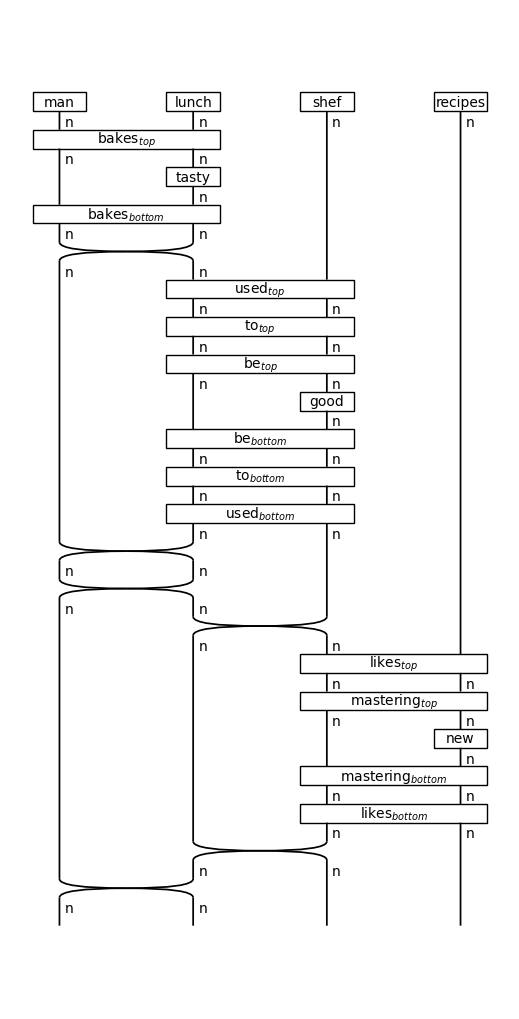

In [12]:
raw_train_diags[0].draw(figsize=(5,10))

### Combination box

As one can see from the example diagram above, we need a means to combine the output wires of the diagram and just output a single wire at the end. This is easily done by adding a {py:class}`.grammar.Box` whose domain is the current diagram output and whose codomain is a single wire which we give the type `T` for `'text'`.

In [13]:
from lambeq import AtomicType
from lambeq.backend.grammar import Box, Ty


# Declare the types we will use
N = AtomicType.NOUN
T = Ty('t')     # 't' for 'text'

# Add fan-in box as last layer for each diagram
def add_fan_in_box(diag):
    fan_in_box = Box(name='fan in',
                     dom=diag.cod,
                     cod=T)
    diag >>= fan_in_box
    return diag

train_diags = [add_fan_in_box(d) for d in raw_train_diags]
dev_diags = [add_fan_in_box(d) for d in raw_dev_diags]
test_diags = [add_fan_in_box(d) for d in raw_test_diags]

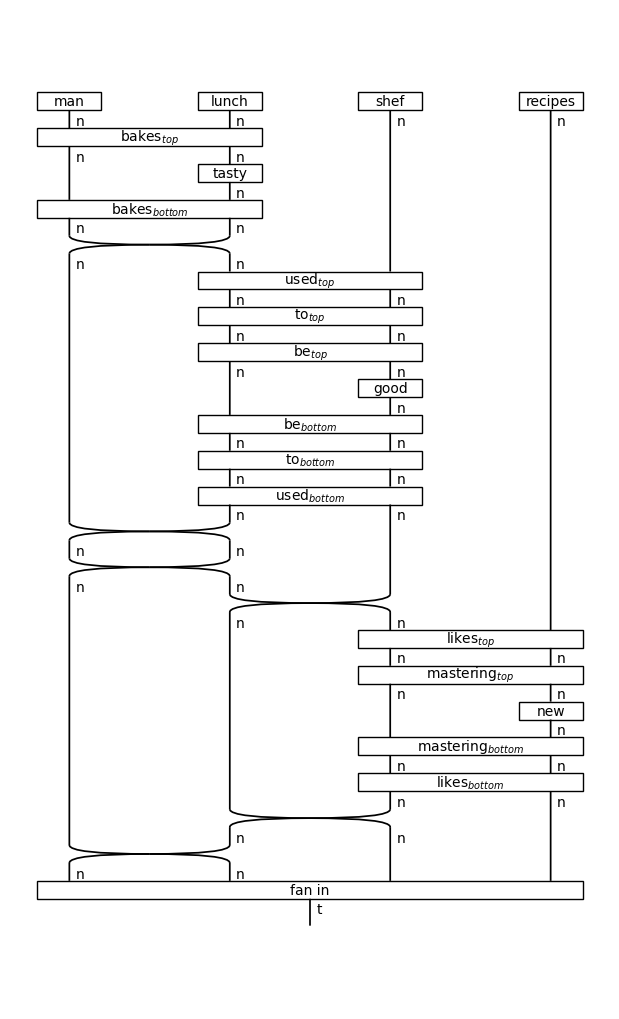

In [15]:
train_diags[0].draw(figsize=(6, 10))

There will be several versions of this 'fan in' box - they only vary on the number of noun wires in its domain.

### Create circuits

In order to run the experiments on a quantum computer, we apply a quantum {term}`ansatz <ansatz (plural: ansätze)>` to the string diagrams. For this experiment, we will use a {py:class}`.Sim4Ansatz`, where noun wires (`n`) and text wires (`t`) are represented by one-qubit systems.

In [16]:
from lambeq import Sim4Ansatz


ansatz = Sim4Ansatz({N: 1, T: 1}, n_layers=3)

train_circs = [ansatz(diag) for diag in train_diags]
dev_circs = [ansatz(diag) for diag in dev_diags]
test_circs = [ansatz(diag) for diag in test_diags]

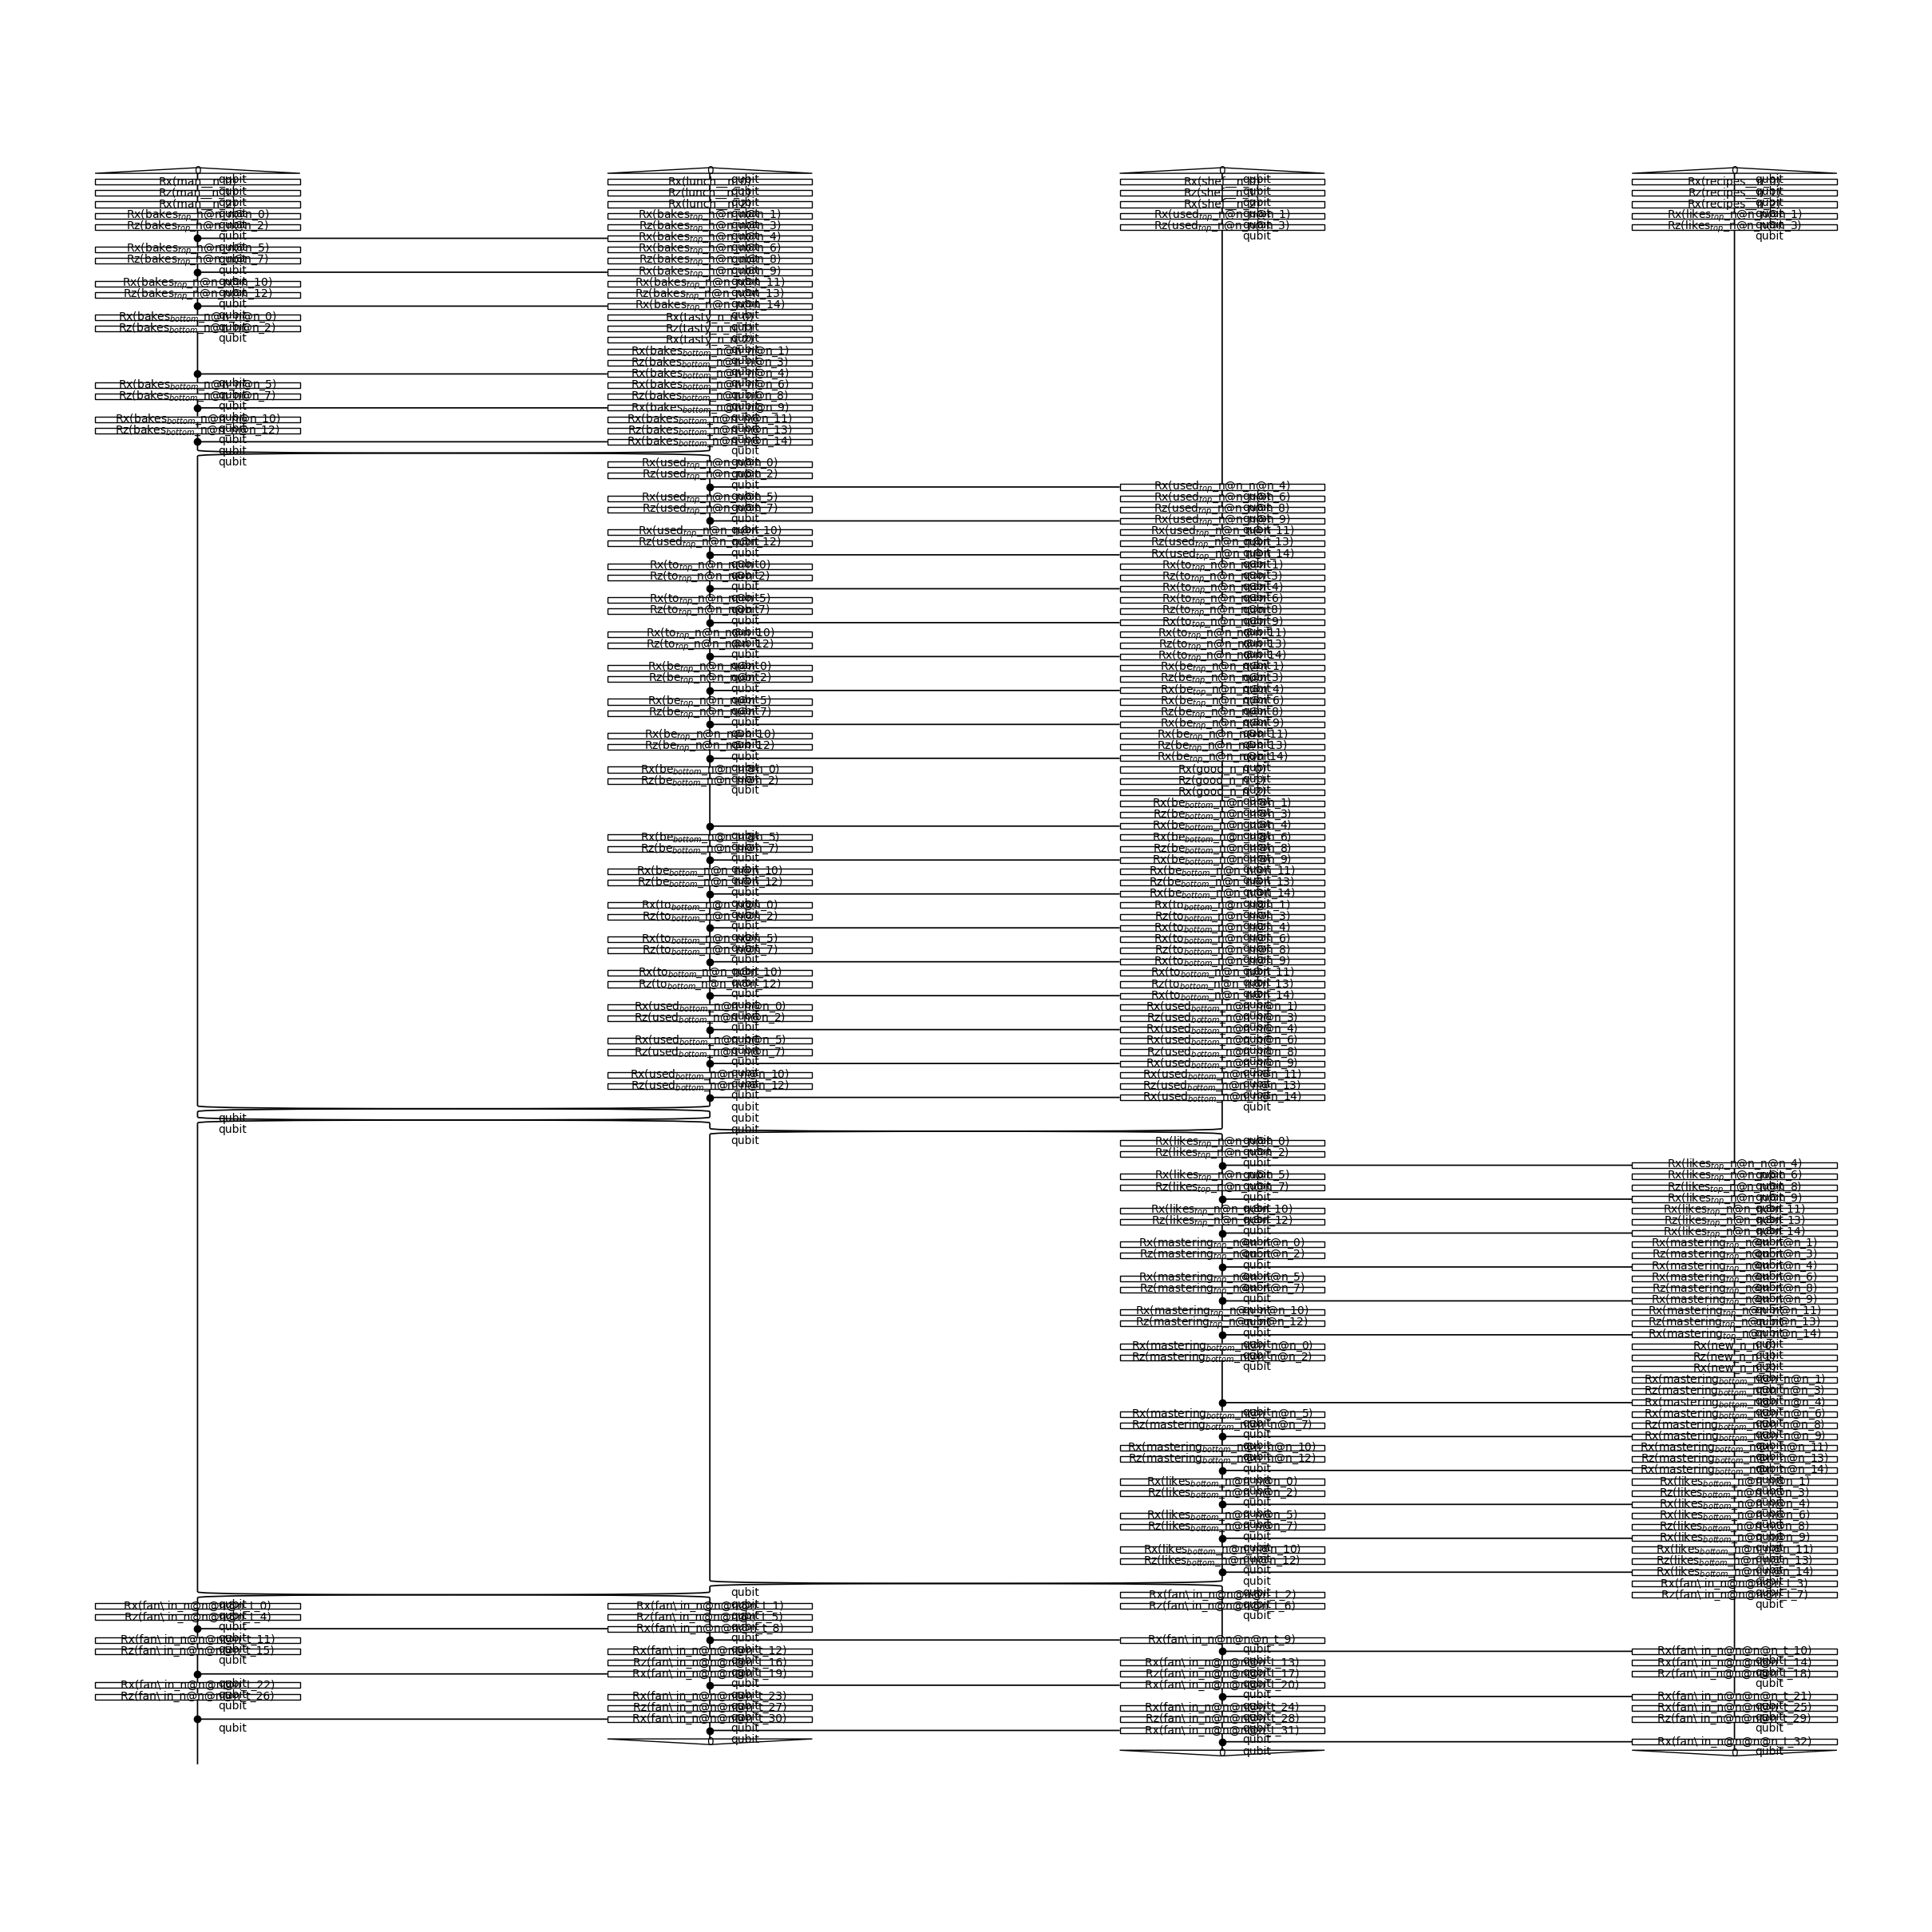

In [18]:
train_circs[0].draw(figsize=(24, 24))

## Training

### Instantiate model

We instantiate a {py:class}`.PennyLaneModel`, by passing all diagrams to the class method {py:meth}`.PennyLaneModel.from_diagrams`.

We also set `probabilities=True` so that the model outputs probabilities, rather than quantum states, which follows the behaviour of real quantum computers.

Furthermore, we set `normalize=True` so that the output probabilities sum to one. This helps to prevent passing very small values to any following layers in a hybrid model.

In [19]:
from lambeq import PennyLaneModel


all_circs = train_circs + dev_circs + test_circs

# if no backend_config is provided, the default is used, which is the same as below
backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PennyLaneModel.from_diagrams(all_circs,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Running this model on a real quantum computer takes a significant amount of time as the circuits must be sent to the backend and queued, so in this tutorial we will use `model`, which uses the default {term}`PennyLane` simulator, 'default.qubit'.

### Create datasets

To facilitate data shuffling and batching, `lambeq` provides a native {py:class}`.Dataset` class. Shuffling is enabled by default, and if not specified, the batch size is set to the length of the dataset.

In [20]:
from lambeq import Dataset


train_dataset = Dataset(train_circs,
                        train_labels,
                        batch_size=BATCH_SIZE)

dev_dataset = Dataset(dev_circs,
                      dev_labels,
                      shuffle=False)

Training can either by done using the {py:class}`.PytorchTrainer`, or by using native PyTorch. We give examples of both in the following section.

### Define loss and evaluation metric

When using {py:class}`.PytorchTrainer` we first define our evaluation metrics and loss function, which in this case will be the accuracy and the mean-squared error, respectively.

In [21]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)


def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, torch.Tensor(y)
    )

### Initialise trainer

As {term}`PennyLane` is compatible with PyTorch autograd, {py:class}`.PytorchTrainer` can automatically use many of the PyTorch optimizers, such as Adam to train our model.

In [22]:
from lambeq import PytorchTrainer


trainer = PytorchTrainer(
    model=model,
    loss_function=loss,
    optimizer=torch.optim.Adam,
    learning_rate=LEARNING_RATE,
    epochs=EPOCHS,
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    use_tensorboard=False,
    verbose='text',
    seed=SEED)

### Train

We can now pass the datasets to the {py:meth}`~lambeq.Trainer.fit` method of the trainer to start the training.

In [23]:
trainer.fit(train_dataset, dev_dataset)

Epoch 1:   train/loss: 0.9695   valid/loss: 1.0455   train/time: 4m15s   valid/time: 1m24s   train/acc: 0.5000   valid/acc: 0.5000
Epoch 2:   train/loss: 1.2423   valid/loss: 0.8468   train/time: 4m18s   valid/time: 1m26s   train/acc: 0.5167   valid/acc: 0.4500
Epoch 3:   train/loss: 1.4184   valid/loss: 0.8690   train/time: 4m19s   valid/time: 1m27s   train/acc: 0.5333   valid/acc: 0.5667
Epoch 4:   train/loss: 0.4773   valid/loss: 1.0767   train/time: 4m20s   valid/time: 1m26s   train/acc: 0.5889   valid/acc: 0.4333
Epoch 5:   train/loss: 0.9689   valid/loss: 0.8239   train/time: 4m23s   valid/time: 1m26s   train/acc: 0.5333   valid/acc: 0.6000
Epoch 6:   train/loss: 0.9354   valid/loss: 0.8176   train/time: 4m25s   valid/time: 1m29s   train/acc: 0.5333   valid/acc: 0.5500
Epoch 7:   train/loss: 1.0967   valid/loss: 0.9583   train/time: 4m27s   valid/time: 1m28s   train/acc: 0.5222   valid/acc: 0.4500
Epoch 8:   train/loss: 0.5902   valid/loss: 0.8774   train/time: 4m28s   valid/time

## Results

Finally, we visualise the results and evaluate the model on the test data.

Final test accuracy: 0.9666666666666667


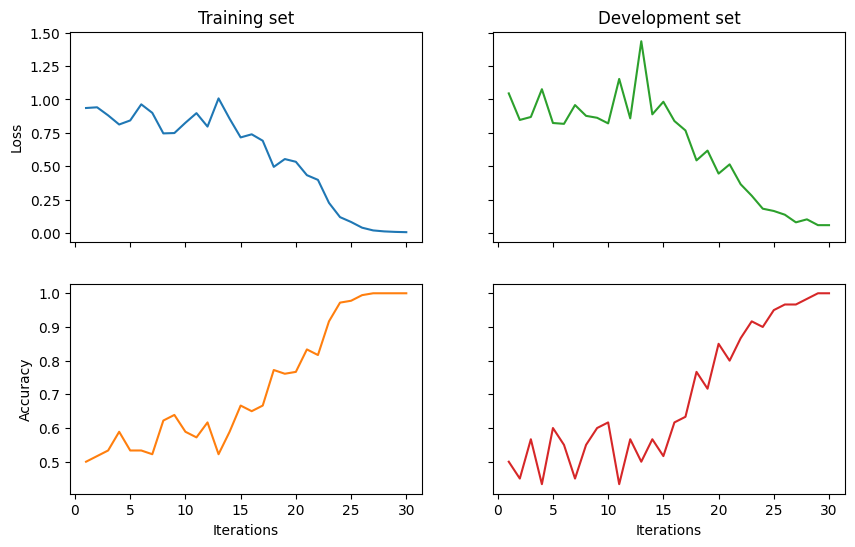

In [24]:
import matplotlib.pyplot as plt


fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2,
                                                     sharex=True,
                                                     sharey='row',
                                                     figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs+1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# print test accuracy
pred = model(test_circs)
labels = torch.tensor(test_labels)

print('Final test accuracy: {}'.format(acc(pred, labels)))